## Project Overview

In previous projects, we focused on building a single model and applying various machine learning concepts such as outlier handling, k-fold cross-validation, and regularization.  

In this project, we'll take a more iterative approach. We'll begin with a **reference model** and progressively optimize it.  

Task is to predict the **extent of forest fire damage** using the **Forest Fires dataset** from the UCI Machine Learning Repository. This dataset includes details about individual fires, the resulting damage, and meteorological conditions at the time. By analyzing these features, we aim to understand how they can be used to predict potential future fire damage.

We’ll start by initializing our **baseline linear regression model** before moving into optimization steps.

In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
fires = pd.read_csv("fires.csv")

In [4]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [5]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [6]:
area = fires['area']

print("\nBASIC STATISTICS:")
print(f"Count: {len(area)}")
print(f"Mean: {area.mean():.2f}")
print(f"Median: {area.median():.2f}")
print(f"Standard Deviation: {area.std():.2f}")
print(f"Min: {area.min():.2f}")
print(f"Max: {area.max():.2f}")
print(f"Zeros: {(area == 0).sum()} ({(area == 0).mean()*100:.1f}%)")


BASIC STATISTICS:
Count: 517
Mean: 12.85
Median: 0.52
Standard Deviation: 63.66
Min: 0.00
Max: 1090.84
Zeros: 247 (47.8%)


In [7]:
print("PERCENTILES:")
percentiles = [25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(area, p):.2f}")

PERCENTILES:
25th percentile: 0.00
50th percentile: 0.52
75th percentile: 6.57
90th percentile: 25.26
95th percentile: 48.71
99th percentile: 194.76


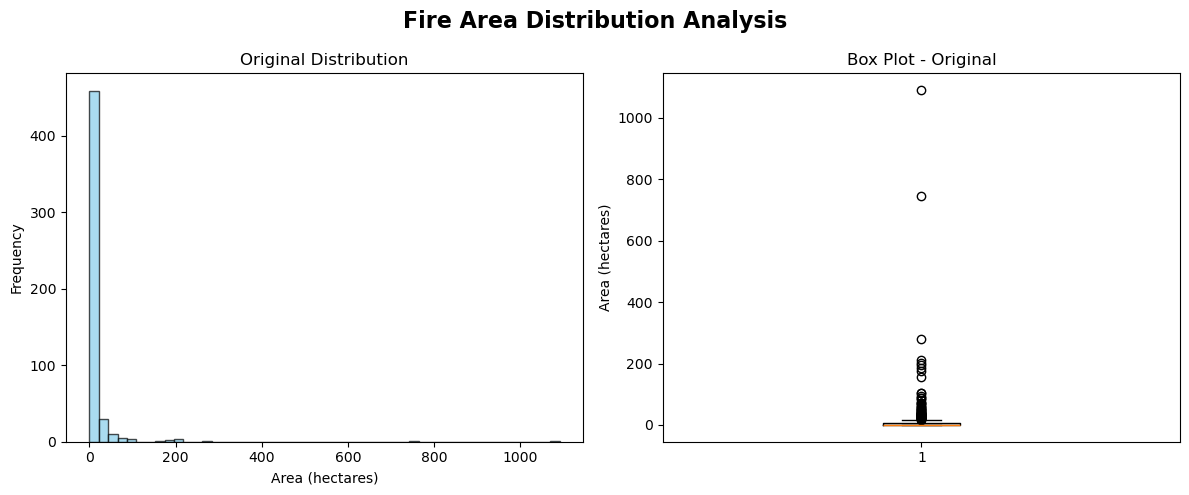

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Fire Area Distribution Analysis', fontsize=16, fontweight='bold')

axes[0].hist(area, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Area (hectares)')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(area)
axes[1].set_title('Box Plot - Original')
axes[1].set_ylabel('Area (hectares)')

plt.tight_layout()
plt.show()

The target variable **`area`** is highly right-skewed due to the presence of extremely damaging fires, while many rows have zero or near-zero values.  
To reduce skewness and improve model performance, we will apply a **log transformation**.  

Since the logarithm of 0 is undefined, we will add 1 to all `area` values before transformation:

$\text{area\_log} = \log(\text{area} + 1)$

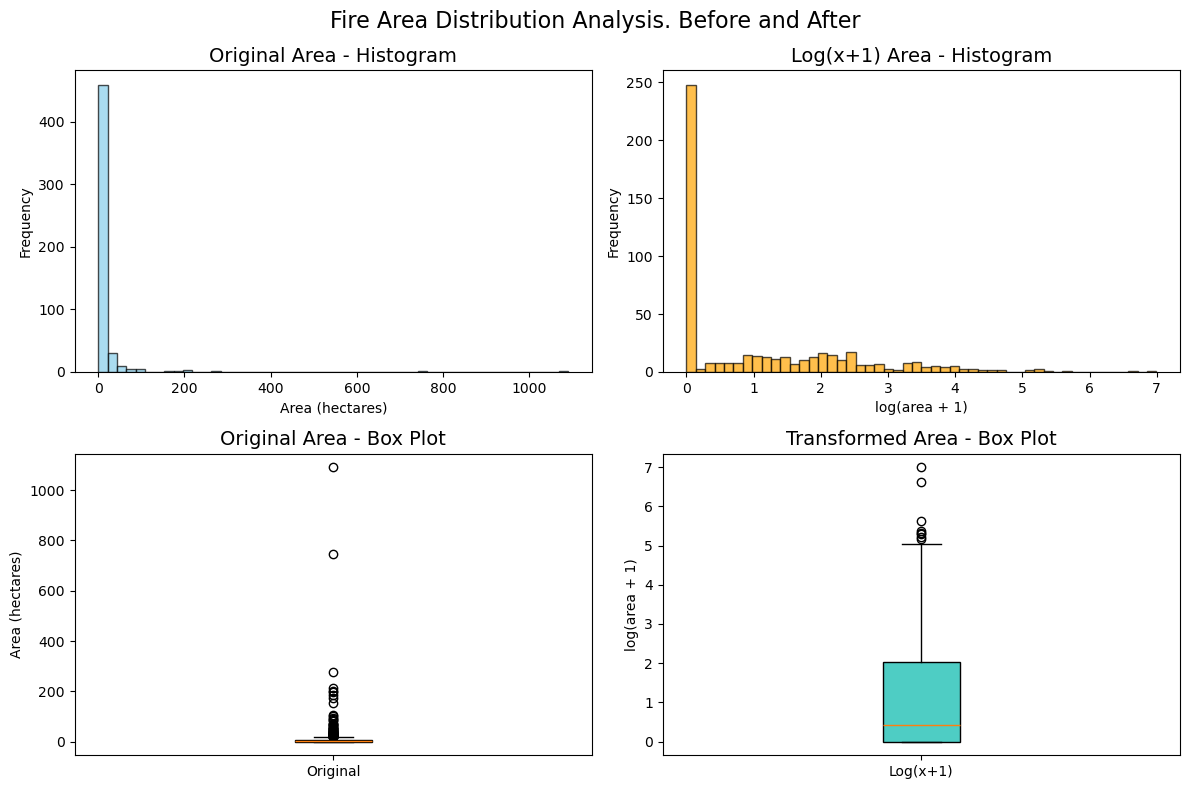

In [16]:
fires['area_transformed'] = np.log1p(fires['area'])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Fire Area Distribution Analysis. Before and After', fontsize=16)

axes[0, 0].hist(fires['area'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Original Area - Histogram', fontsize=14)
axes[0, 0].set_xlabel('Area (hectares)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(fires['area_transformed'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].set_title('Log(x+1) Area - Histogram', fontsize=14)
axes[0, 1].set_xlabel('log(area + 1)')
axes[0, 1].set_ylabel('Frequency')

bp1 = axes[1, 0].boxplot(fires['area'], patch_artist=True, labels=['Original'])
bp1['boxes'][0].set_facecolor('#ff6b6b')
axes[1, 0].set_title('Original Area - Box Plot', fontsize=14)
axes[1, 0].set_ylabel('Area (hectares)')

bp2 = axes[1, 1].boxplot(fires['area_transformed'], patch_artist=True, labels=['Log(x+1)'])
bp2['boxes'][0].set_facecolor('#4ecdc4')
axes[1, 1].set_title('Transformed Area - Box Plot', fontsize=14)
axes[1, 1].set_ylabel('log(area + 1)')

plt.tight_layout()
plt.show()

Instead of using the **`month`** variable directly, we'll create a new binary feature called **`summer`**.  
This feature will take the value **1** if the fire occurred during the summer months and **0** otherwise.  
The rationale is that summer months generally have higher temperatures and drier conditions, which can increase the likelihood and severity of forest fires.

In [19]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = fires["month"].apply(is_summer_month)

In [31]:
fires[weather_cols].info()
fires[weather_cols].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    469 non-null    float64
 1   DMC     496 non-null    float64
 2   DC      474 non-null    float64
 3   ISI     515 non-null    float64
 4   temp    496 non-null    float64
 5   RH      487 non-null    float64
 6   wind    482 non-null    float64
 7   rain    485 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0
1,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0
2,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0
3,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2
4,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0


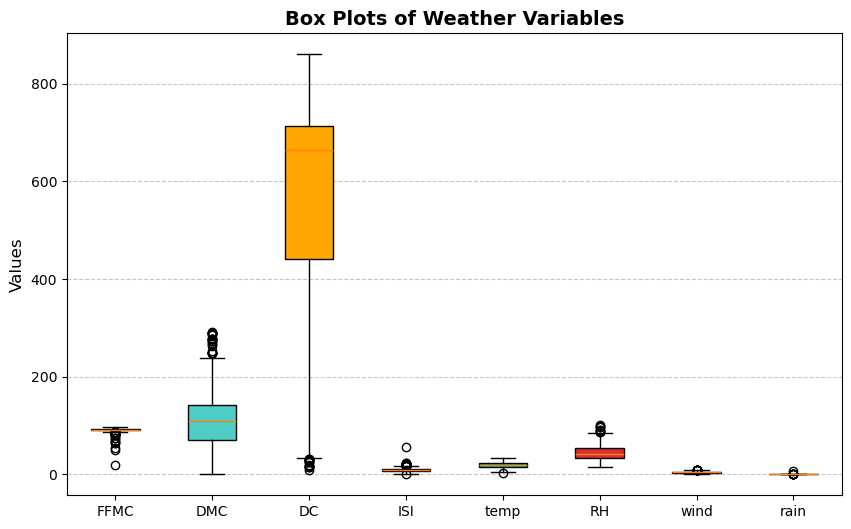

In [33]:
weather_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

plt.figure(figsize=(10, 6))

bp = plt.boxplot([fires[col].dropna() for col in weather_cols],
                 patch_artist=True,
                 labels=weather_cols)

colors = ['#ff6b6b', '#4ecdc4', '#ffa600', '#6a4c93', '#00b894', '#d63031', '#0984e3', '#fdcb6e']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)

plt.title('Box Plots of Weather Variables', fontsize=14, fontweight='bold')
plt.ylabel('Values', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
for col in weather_cols:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((fires[col] < lower_bound) | (fires[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


Based on the **boxplot visualization**, it initially appears that there are outliers in the dataset.  
However, after applying the **interquartile range** (IQR) test, we find that there are actually no outliers in the weather-related columns.  
This indicates that the extreme values seen in the boxplot are likely part of the natural variation in the data rather than anomalies.

Next, we handle missing values by **imputing the data**.  
Columns with indexes from 5 to 13 contain missing values.  
For numerical columns, we fill missing values with the column mean to preserve the overall distribution.  
For categorical columns, we use the most frequent value (mode) to maintain consistency without introducing bias.

In [48]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        517 non-null    int64  
 1   X                 517 non-null    int64  
 2   Y                 517 non-null    int64  
 3   month             517 non-null    object 
 4   day               517 non-null    object 
 5   FFMC              469 non-null    float64
 6   DMC               496 non-null    float64
 7   DC                474 non-null    float64
 8   ISI               515 non-null    float64
 9   temp              496 non-null    float64
 10  RH                487 non-null    float64
 11  wind              482 non-null    float64
 12  rain              485 non-null    float64
 13  area              517 non-null    float64
 14  area_transformed  517 non-null    float64
 15  summer            517 non-null    int64  
dtypes: float64(10), int64(4), object(2)
memory u

In [55]:
imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] 
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


In [59]:
imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    517 non-null    float64
 1   DMC     517 non-null    float64
 2   DC      517 non-null    float64
 3   ISI     517 non-null    float64
 4   temp    517 non-null    float64
 5   RH      517 non-null    float64
 6   wind    517 non-null    float64
 7   rain    517 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


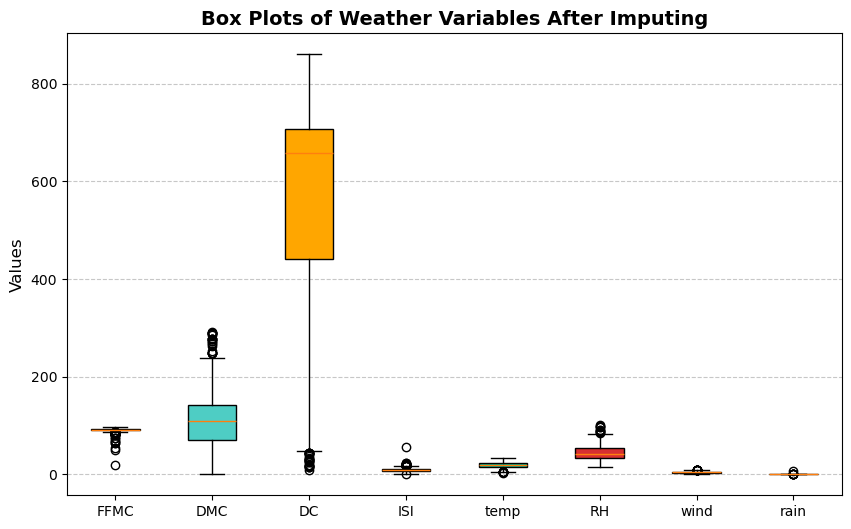

In [63]:
weather_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

plt.figure(figsize=(10, 6))

bp = plt.boxplot([imputed[col].dropna() for col in weather_cols],
                 patch_artist=True,
                 labels=weather_cols)

colors = ['#ff6b6b', '#4ecdc4', '#ffa600', '#6a4c93', '#00b894', '#d63031', '#0984e3', '#fdcb6e']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)

plt.title('Box Plots of Weather Variables After Imputing', fontsize=14, fontweight='bold')
plt.ylabel('Values', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [65]:
for col in imputed:
    quartiles = np.percentile(imputed[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers = sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 53 according to the boxplot method.
The DMC column has 22 according to the boxplot method.
The DC column has 25 according to the boxplot method.
The ISI column has 23 according to the boxplot method.
The temp column has 9 according to the boxplot method.
The RH column has 10 according to the boxplot method.
The wind column has 13 according to the boxplot method.
The rain column has 8 according to the boxplot method.


In [67]:
valid_ranges = {
    'FFMC': (18.7, 96.2),
    'DMC': (1.1, 291.3),
    'DC': (7.9, 860.6),
    'ISI': (0.0, 56.1),
    'temp': (2.2, 33.3),
    'RH': (15.0, 100.0),
    'wind': (0.4, 9.4),   
    'rain': (0.0, 6.4)    
}

for col, (low, high) in valid_ranges.items():
    imputed[col] = imputed[col].clip(lower=low, upper=high)

In [69]:
for col in imputed:
    quartiles = np.percentile(imputed[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers = sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 53 according to the boxplot method.
The DMC column has 22 according to the boxplot method.
The DC column has 25 according to the boxplot method.
The ISI column has 23 according to the boxplot method.
The temp column has 9 according to the boxplot method.
The RH column has 10 according to the boxplot method.
The wind column has 13 according to the boxplot method.
The rain column has 8 according to the boxplot method.


### Outlier Detection and Domain-Based Capping

Initially, we detected potential outliers in the weather variables using the **boxplot/IQR method**. 
This approach flagged many extreme values as outliers:

- FFMC: 53  
- DMC: 22  
- DC: 25  
- ISI: 23  
- temp: 9  
- RH: 10  
- wind: 13  
- rain: 8  

However, most of these values were within the **known physical ranges** for each variable based on the dataset's metadata 
and the Fire Weather Index system.  
For example, FFMC values range from 18.7 to 96.2, DC values from 7.9 to 860.6, etc.

We applied **domain-based capping** to ensure no value exceeded its physical limits after KNN imputation.  
After capping, the number of IQR-based outliers did not change.  

**Interpretation:**  
The flagged values from the IQR method were not truly erroneous — they were valid extreme weather events.  
Using domain-based validation ensures data integrity while preserving important variation in the dataset.

### Data Scaling

After imputing missing values, we scale the data to ensure all features are on the same scale.  
This step is important because features measured in different units can disproportionately influence the model.  
We apply standardization, which transforms each feature to have a mean of 0 and a standard deviation of 1, making the model training more stable and improving performance.


In [76]:
scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

final = pd.concat([fires["summer"], scaled], axis=1)

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


### Subset Selection

With a cleaned dataset containing only numerical features and some initial visual exploration completed, we can begin the modeling process. Since the dataset contains a relatively large number of features, we'll apply **feature selection** to identify which variables are most useful for making predictions.

This approach is entirely data-driven, focusing on **feature importance** to guide our decisions. The goal is to select a subset of features that will serve as the foundation for an initial model, which we can later refine and optimize.


In [95]:
y = fires["area_transformed"]

lr = LinearRegression()

for n in [2, 4, 6]:
    sfs = SequentialFeatureSelector(estimator=lr,
                                    n_features_to_select=n,
                                    direction="forward")
    sfs.fit(final, y)
    print(f"Features selected in {n} feature model:",
          sfs.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [97]:
for n in [2, 4, 6]:
    sfs = SequentialFeatureSelector(estimator=lr,
                                    n_features_to_select=n,
                                    direction="backward")
    sfs.fit(final, y)
    print(f"Features selected in {n} feature model:",
          sfs.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [116]:
forward_selected = {
    "Forward_2": ['FFMC', 'DC'],
    "Forward_4": ['FFMC', 'DC', 'RH', 'wind'],
    "Forward_6": ['summer', 'FFMC', 'DC', 'ISI', 'RH', 'wind']
}

backward_selected = {
    "Backward_2": ['DC', 'wind'],
    "Backward_4": ['FFMC', 'DC', 'RH', 'wind'],
    "Backward_6": ['summer', 'FFMC', 'DC', 'ISI', 'RH', 'wind']
}

X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.2, random_state=42)

def evaluate_model(features):
    model = LinearRegression()
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse

for name, features in {**forward_selected, **backward_selected}.items():
    r2, rmse = evaluate_model(features)
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

Forward_2: R² = 0.0011, RMSE = 1.4817
Forward_4: R² = 0.0158, RMSE = 1.4707
Forward_6: R² = 0.0204, RMSE = 1.4673
Backward_2: R² = 0.0189, RMSE = 1.4685
Backward_4: R² = 0.0158, RMSE = 1.4707
Backward_6: R² = 0.0204, RMSE = 1.4673


### Developing Candidate Models

The features selected through subset selection still feed into **linear models** at their core. While linear regression is powerful and widely used, some problems have **non-linear relationships** that standard linear models can’t capture effectively. 

To address this, we can explore more flexible models, such as **polynomial regression** and **splines**. These approaches allow us to model curvature and complex patterns in the data.

However, greater flexibility comes with a risk — **overfitting**. Adding higher-degree polynomials, more spline knots, or a large number of features can lead to excellent training performance but poor generalization to unseen data. To combat this, we can use **regularization** techniques.

Developing candidate models is often an iterative process. While many models may perform poorly, each experiment can provide valuable insight into how to refine and improve our approach.

In [120]:
ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  1372.2342342342342
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


### Regularization Results

To address potential overfitting, we applied **Ridge** and **LASSO** regression with tuned hyperparameters.  

- Ridge tuning parameter (α): 1372.23  
- LASSO tuning parameter (α): 10000.0  

Interpretation:
- Ridge regression retains all features but shrinks their coefficients to reduce variance.  
- LASSO regression, at this high penalty level, performed aggressive feature selection, eliminating all predictors.  

The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any.

### K-Fold Cross-Validation

Now that we have a few candidate models, we can evaluate all of them using **k-fold cross-validation**.  

K-fold cross-validation works by splitting the dataset into k equally sized folds. The model is trained on k-1 folds and tested on the remaining fold, repeating this process k times so that every fold serves as a test set exactly once.  

This approach provides a more reliable estimate of model performance on unseen data compared to a single train–test split, as it reduces variance caused by how the data is divided.

In [143]:
scoring = "neg_mean_squared_error"

reference_cv = cross_val_score(LinearRegression(), final[["wind", "temp"]], y, cv=5, scoring=scoring)

fw2_cv = cross_val_score(LinearRegression(), final[forward_selected["Forward_2"]], y, cv=5, scoring=scoring)
fw4_cv = cross_val_score(LinearRegression(), final[forward_selected["Forward_4"]], y, cv=5, scoring=scoring)
fw6_cv = cross_val_score(LinearRegression(), final[forward_selected["Forward_6"]], y, cv=5, scoring=scoring)

bw2_cv = cross_val_score(LinearRegression(), final[backward_selected["Backward_2"]], y, cv=5, scoring=scoring)
bw4_cv = cross_val_score(LinearRegression(), final[backward_selected["Backward_4"]], y, cv=5, scoring=scoring)
bw6_cv = cross_val_score(LinearRegression(), final[backward_selected["Backward_6"]], y, cv=5, scoring=scoring)

ridge_cv = cross_val_score(Ridge(alpha=1372.23), final, y, cv=5, scoring=scoring)

def print_rmse(name, scores):
    rmse = np.sqrt(-scores)
    print(f"{name}: RMSE = {rmse.mean():.4f} ± {rmse.std():.4f}")

print_rmse("Reference", reference_cv)
print_rmse("Forward_2", fw2_cv)
print_rmse("Forward_4", fw4_cv)
print_rmse("Forward_6", fw6_cv)
print_rmse("Backward_2", bw2_cv)
print_rmse("Backward_4", bw4_cv)
print_rmse("Backward_6", bw6_cv)
print_rmse("Ridge", ridge_cv)

Reference: RMSE = 1.4443 ± 0.3446
Forward_2: RMSE = 1.4346 ± 0.3398
Forward_4: RMSE = 1.4434 ± 0.3319
Forward_6: RMSE = 1.4588 ± 0.3342
Backward_2: RMSE = 1.4359 ± 0.3341
Backward_4: RMSE = 1.4434 ± 0.3319
Backward_6: RMSE = 1.4588 ± 0.3342
Ridge: RMSE = 1.4401 ± 0.3418


### Model Selection with Cross-Validation

We compared multiple linear regression models (forward selection, backward selection, and Ridge regression) using **5-fold cross-validation**. The performance metric was the **root mean squared error (RMSE)**.

**Interpretation:**
- The **Forward_2** and **Backward_2** models achieved the lowest RMSE, albeit by a very small margin compared to the reference model.
- Adding more features (4 or 6) did not yield meaningful performance gains and, in some cases, slightly worsened the RMSE.
- Ridge regression produced results similar to the reference model, indicating minimal benefit from regularization under the current settings.
- Given the negligible differences, **simpler models with only 2 features** appear to be the most efficient choice, balancing predictive accuracy and interpretability.
